<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Predicción de próxima palabra

### Objetivo
El objetivo es entrenar un modelo de lenguaje basado en arquitectura de redes recurrentes a partir de un corpus de texto. En el transcurso del ejercicio se explorarán técnicas de generación de secuencias y se medirá la calidad de las mismas calculando la perplejidad. Parte del ejercicio consiste en estructurar adecuadamente el dataset para este problema.


In [1]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

### Datos
Utilizaremos como dataset el conjunto de cuentos en español. En particular, nos enfocamos en cuentos de **Jorge Luis Borges**, recopilados por Karen Palacio en su repositorio:
https://github.com/karen-pal/borges/tree/master

In [2]:

# Descargar la carpeta de dataset
import os
import platform
if os.access('full_corpus.csv', os.F_OK) is False:
      if platform.system() == 'Windows':
          !curl https://raw.githubusercontent.com/karen-pal/borges/refs/heads/master/datasets/full_corpus.csv -o full_corpus.csv
      else:
          !wget full_corpus.csv https://raw.githubusercontent.com/karen-pal/borges/refs/heads/master/datasets/full_corpus.csv
else:
    print("El dataset ya se encuentra descargado")

--2025-03-27 01:35:27--  http://full_corpus.csv/
Resolving full_corpus.csv (full_corpus.csv)... failed: Name or service not known.
wget: unable to resolve host address ‘full_corpus.csv’
--2025-03-27 01:35:28--  https://raw.githubusercontent.com/karen-pal/borges/refs/heads/master/datasets/full_corpus.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6022847 (5.7M) [text/plain]
Saving to: ‘full_corpus.csv’

full_corpus.csv     100%[===================>]   5.74M  --.-KB/s    in 0.1s    

2025-03-27 01:35:28 (59.1 MB/s) - ‘full_corpus.csv’ saved [6022847/6022847]

FINISHED --2025-03-27 01:35:28--
Total wall clock time: 0.4s
Downloaded: 1 files, 5.7M in 0.1s (59.1 MB/s)


In [3]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv('full_corpus.csv').drop(columns = ["Unnamed: 0"])
df.head()

,link,text,title,metadata,author
0,https://ciudadseva.com/texto/aforismos/,Los enanos tienen una especie de sexto sentido...,Aforismos,[Minicuento - Texto completo.],Augusto Monterroso
1,https://ciudadseva.com/texto/caballo-imaginand...,"“A pesar de lo que digan, la idea de un cielo ...",Caballo imaginando a Dios,[Minicuento - Texto completo.],Augusto Monterroso
2,https://ciudadseva.com/texto/como-acercarse-a-...,"Con precaución, como a cualquier cosa pequeña....",Cómo acercarse a las fábulas,[Minicuento - Texto completo.],Augusto Monterroso
3,https://ciudadseva.com/texto/dejar-de-ser-mono/,EL espíritu de investigación no tiene límites....,Dejar de ser mono,[Minicuento - Texto completo.],Augusto Monterroso
4,https://ciudadseva.com/texto/el-burro-y-la-fla...,Tirada en el campo estaba desde hacía tiempo u...,El burro y la flauta,[Minicuento - Texto completo.],Augusto Monterroso


In [4]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 719


In [5]:
#Autores presentes
df.author.value_counts()

,count
author,
Jorge Luis Borges,62
Julio Cortázar,55
Baldomero Lillo,50
Augusto Monterroso,45
Juan José Arreola,45
Alfonso Reyes,37
Enrique Anderson Imbert,36
Mario Benedetti,33
Julio Ramón Ribeyro,27


In [6]:
#Nos quedamos con los cuentos escritos por Borges
df_borges = df[df.author == 'Jorge Luis Borges']

In [7]:
# Veamos la lista de cuentos incluídos:
df_borges.title

,title
144,Abel y Caín
145,Adrogué
146,Alguien soñará
147,Andrés Armoa
148,Argumentum ornithologicum
...,...
201,"Tlön, Uqbar, Orbis Tertius"
202,Tres versiones de Judas
203,Un problema
204,Un sueño


In [8]:
df_borges[ df_borges.title == 'El Aleph'].text.iloc[0]

'La candente mañana de febrero en que Beatriz Viterbo murió, después de una imperiosa agonía que no se rebajó un solo instante ni al sentimentalismo ni al miedo, noté que las carteleras de fierro de la Plaza Constitución habían renovado no sé qué aviso de cigarrillos rubios; el hecho me dolió, pues comprendí que el incesante y vasto universo ya se apartaba de ella y que ese cambio era el primero de una serie infinita. Cambiará el universo pero yo no, pensé con melancólica vanidad; alguna vez, lo sé, mi vana devoción la había exasperado; muerta yo podía consagrarme a su memoria, sin esperanza, pero también sin humillación. Consideré que el treinta de abril era su cumpleaños; visitar ese día la casa de la calle Garay para saludar a su padre y a Carlos Argentino Daneri, su primo hermano, era un acto cortés, irreprochable, tal vez ineludible. De nuevo aguardaría en el crepúsculo de la abarrotada salita, de nuevo estudiaría las circunstancias de sus muchos retratos. Beatriz Viterbo, de perf

Consideraremos que cada secuencia para este dataset es una oración.

Una de las primeras decisiones que hay que tomar es el tamaño de contexto de tokens máximo que puede consumir el modelo. Este podría ser un hiperparámetro del problema.


Para elegir el tamaño de contexto máximo para este problema se puede explorar el dataset, para ello:
- se consideran las palabras como términos.
- se segmentará el texto de todos las oraciones del dataset y ses explorará la cantidad de términos presentes.


In [9]:
# Aquí utilizamos la librería 're' para splitear el texto
import re
delimiters = r'(?<=[.,!?]) +'

In [10]:
# Ejemplo de como funciona
re.split(delimiters, df_borges.text.iloc[0])

['Abel y Caín se encontraron después de la muerte de Abel.',
 'Caminaban por el desierto y se reconocieron desde lejos,',
 'porque los dos eran muy altos.',
 'Los hermanos se sentaron en la tierra,',
 'hicieron un fuego y comieron.',
 'Guardaban silencio,',
 'a la manera de la gente cansada cuando declina el día.',
 'En el cielo asomaba alguna estrella,',
 'que aún no había recibido su nombre.',
 'A la luz de las llamas,',
 'Caín advirtió en la frente de Abel la marca de la piedra y dejó caer el pan que estaba por llevarse a la boca y pidió que le fuera perdonado su crimen.',
 'Abel contestó: —¿Tú me has matado o yo te he matado?',
 'Ya no recuerdo; aquí estamos juntos como antes.',
 '—Ahora sé que en verdad me has perdonado —dijo Caín—,',
 'porque olvidar es perdonar.',
 'Yo trataré también de olvidar.',
 'Abel dijo despacio: —Así es.',
 'Mientras dura el remordimiento dura la culpa.',
 'FIN']

In [11]:
# Para armar el corpus, tomamos cada texto y lo spliteamos como mostramos recién, de forma tal que cada documento sea una oración.
corpus = []
for texto in df_borges.text.to_list():
    corpus += re.split(delimiters, texto)

In [12]:
print(f"El corpus posee {len(corpus)} documentos (oraciones). \n Por ejemplo: {corpus[40:43]}")

El corpus posee 10812 documentos (oraciones). 
 Por ejemplo: ['los ojos.', 'Soñará un mundo sin la máquina y sin esa doliente máquina,', 'el cuerpo.']


### Elegir el tamaño del contexto

In [13]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from tensorflow.keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from tensorflow.keras.utils import pad_sequences # se utilizará para padding


In [14]:
# Transformamos cada oración en una lista de términos utilizando la función de Keras
segmented_sentences = [text_to_word_sequence(sentence) for sentence in corpus]
print( segmented_sentences[0:5])

[['abel', 'y', 'caín', 'se', 'encontraron', 'después', 'de', 'la', 'muerte', 'de', 'abel'], ['caminaban', 'por', 'el', 'desierto', 'y', 'se', 'reconocieron', 'desde', 'lejos'], ['porque', 'los', 'dos', 'eran', 'muy', 'altos'], ['los', 'hermanos', 'se', 'sentaron', 'en', 'la', 'tierra'], ['hicieron', 'un', 'fuego', 'y', 'comieron']]


In [15]:
# calculamos la longitud de cada secuencia
length_sentences = [len(sentence) for sentence in segmented_sentences]

(array([3.718e+03, 2.615e+03, 1.670e+03, 1.104e+03, 6.430e+02, 3.810e+02,
        2.380e+02, 1.630e+02, 1.010e+02, 6.900e+01, 5.400e+01, 1.700e+01,
        1.600e+01, 9.000e+00, 5.000e+00, 4.000e+00, 3.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00]),
 array([ 1. ,  4.1,  7.2, 10.3, 13.4, 16.5, 19.6, 22.7, 25.8, 28.9, 32. ,
        35.1, 38.2, 41.3, 44.4, 47.5, 50.6, 53.7, 56.8, 59.9, 63. ]),
 <BarContainer object of 20 artists>)

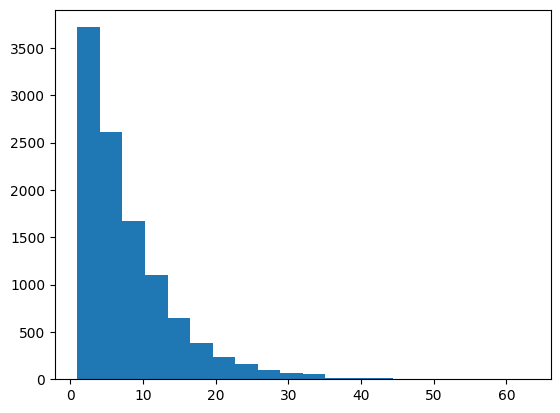

In [16]:
# podemos ver su distribución
plt.hist(length_sentences,bins=20)

In [17]:
# a partir de la distribución de longitudes de secuencias elegimos algún criterio
# para determinar el máximo tamaño de contexto. En este caso es un percentil, pero
# otros criterios también pueden ser válidos con la justificación adecuada.

# el -1 es porque el último token será el target
max_context_size = 10
#max_context_size = int(np.percentile(length_sentences, 90)-1)
# max_context_size = int(np.ceil(np.mean(length_sentences))) # criterio de media
# max_context_size = int(np.ceil(np.median(length_sentences))) # criterio de mediana
print(f'max_context_size: {max_context_size}')

max_context_size: 10


###  Tokenizar

In [18]:
tok = Tokenizer()

# El tokenizer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado. Se utiliza para designar a palabras
# fuera del vocabulario aprendido
tok.fit_on_texts(segmented_sentences)

# Convertimos las palabras a números
# entran palabras -> salen números
tokenized_sentences = tok.texts_to_sequences(segmented_sentences)

In [19]:
tokenized_sentences[0:5]

[[1635, 5, 2017, 15, 2630, 53, 1, 2, 88, 1, 1635],
 [6204, 20, 4, 338, 5, 15, 6205, 101, 439],
 [69, 7, 37, 82, 75, 650],
 [7, 1636, 15, 6206, 6, 2, 93],
 [997, 9, 278, 5, 6207]]

### Organizando y estructurando el dataset

 **Data split**:En este punto tenemos en la variable `tokenized_sentences` los
versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [20]:
tokenized_sentences_train, tokenized_sentences_val, _, _ = train_test_split(tokenized_sentences, tokenized_sentences, test_size=0.2, random_state=42)

**Truncación por contexto**: Vamos a splitear las oraciones que tienen tamaño mayor al contexto máximo, para generarnos más secuencias de entrenamiento. Este paso puede obviarse si el tamaño de contexto máximo es muy grande.

In [21]:
tok_sent = []

for sent in tokenized_sentences_train:

  # si la secuencia tiene más términos que el tamaño de contexto máximo,
  # armo varias sub-secuencias de tamaño máximo
  if len(sent) > (max_context_size+1):
    extra = len(sent)-(max_context_size+1) + 1
    for i in range(extra):
      tok_sent.append(sent[i:i+max_context_size+1])
  else: # si la secuencia tiene menos términos el tamaño de contexto máximo, dejo la secuencia como está
    tok_sent.append(sent)


In [22]:
len(tok_sent)

21707

Ahora aumentamos los datos aprovechando que de una secuencia grande se pueden generar varias más pequeñas:

- *La hermosa casa en el prado*
- *La hermosa*
- *La hermosa casa*
- *La hermosa casa en*
- *La hermosa casa en el*
- *La hermosa casa en el prado*

In [23]:
tok_sent_augm = []

for sent in tok_sent:

  # generamos todas las sub-secuencias
  subseq = [sent[:i+2] for i in range(len(sent)-1)]
  # en esta línea paddeamos al tamaño de contexto máximo
  tok_sent_augm.append(pad_sequences(subseq, maxlen=max_context_size+1, padding='pre'))


In [24]:
# finalmente concatenamos todas las secuencias en un único array de numpy
train_seqs = np.concatenate(tok_sent_augm, axis=0)

In [25]:
train_seqs.shape

(178448, 11)

In [26]:
# y de aquí sacamos las entradas y los targets que consumirá nuestro sistema en
# tiempo de entrenamiento
X = train_seqs[:, :-1]
y = train_seqs[:, -1]

In [27]:
X[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 4], dtype=int32)

In [28]:
y[0]

np.int32(5084)

In [29]:
# Palabras del vocabulario
tok.index_word[217]

'luz'

In [30]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

15002

In [31]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'de': 1, 'la': 2, 'que': 3, 'el': 4, 'y': 5, 'en': 6, 'los': 7, 'a': 8, 'un': 9, 'no': 10, 'una': 11, 'del': 12, 'las': 13, 'lo': 14, 'se': 15, 'con': 16, 'es': 17, 'me': 18, 'su': 19, 'por': 20, 'le': 21, 'al': 22, 'o': 23, 'era': 24, 'para': 25, 'había': 26, 'pero': 27, 'como': 28, 'más': 29, 'mi': 30, 'esa': 31, 'yo': 32, 'hombre': 33, 'ese': 34, 'sin': 35, 'ya': 36, 'dos': 37, 'sus': 38, 'si': 39, 'fue': 40, 'otro': 41, 'son': 42, 'ha': 43, 'hombres': 44, 'vez': 45, 'noche': 46, 'hay': 47, 'he': 48, 'fin': 49, 'también': 50, 'todos': 51, 'él': 52, 'después': 53, 'dijo': 54, 'uno': 55, 'todo': 56, 'estaba': 57, 'años': 58, 'casi': 59, 'otra': 60, 'tiempo': 61, 'ni': 62, 'ahora': 63, 'cuando': 64, 'entre': 65, 'libro': 66, 'historia': 67, 'este': 68, 'porque': 69, 'nombre': 70, 'hasta': 71, 'cada': 72, 'nos': 73, 'solo': 74, 'muy': 75, 'sobre': 76, 'tal': 77, 'día': 78, 'dios': 79, 'otros': 80, 'palabras': 81, 'eran': 82, 'ser': 83, 'nadie': 84, 'antes': 85, 'vi': 86, 'casa': 87, 'm

In [32]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'encontraron': 3, 'abel': 4, 'caín': 4, 'de': 3643, 'después': 117, 'se': 700, 'y': 2079, 'muerte': 80, 'la': 2774, 'lejos': 17, 'el': 2512, 'reconocieron': 1, 'caminaban': 1, 'por': 507, 'desde': 67, 'desierto': 21, 'los': 1389, 'porque': 98, 'altos': 12, 'eran': 85, 'dos': 178, 'muy': 95, 'en': 1915, 'tierra': 74, 'sentaron': 1, 'hermanos': 5, 'hicieron': 8, 'un': 1384, 'fuego': 25, 'comieron': 1, 'silencio': 15, 'guardaban': 2, 'gente': 26, 'declina': 1, 'cansada': 2, 'manera': 24, 'día': 92, 'cuando': 103, 'a': 1386, 'asomaba': 2, 'alguna': 67, 'cielo': 32, 'estrella': 4, 'su': 557, 'nombre': 97, 'que': 2451, 'recibido': 4, 'no': 1123, 'había': 360, 'aún': 16, 'llamas': 6, 'luz': 33, 'las': 862, 'fuera': 45, 'le': 402, 'advirtió': 9, 'frente': 12, 'estaba': 115, 'pan': 7, 'dejó': 20, 'pidió': 9, 'marca': 6, 'caer': 9, 'perdonado': 3, 'boca': 18, 'piedra': 32, 'llevarse': 1, 'crimen': 18, 'contestó': 9, 'me': 550, '—¿tú': 1, 'yo': 238, 'he': 131, 'matado'


### Definir el modelo

In [33]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size+1,
                    output_dim=50,
                    input_shape=(max_context_size,)))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64)) # La última capa LSTM no lleva return_sequences
model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model.add(Dense(vocab_size+1, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
# notar que usamos la versión Sparse para utilizar sólo índices en lugar de OHE
model.compile(loss=SparseCategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 10, 50)              │         750,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 10, 64)              │          29,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 15003)               │         495,099 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,309,793 (5.00 MB)

 Trainable params: 1,309,793 (5.00 MB)

 Non-trainable params: 0 (0.00 B)

Dado que por el momento no hay implementaciones adecuadas de la perplejidad que puedan operar en tiempo de entrenamiento, armaremos un Callback *ad-hoc* que la calcule en cada epoch.

**Nota**: un Callback es una rutina gatillada por algún evento, son muy útiles para relevar datos en diferentes momentos del desarrollo del modelo. En este caso queremos hacer un cálculo cada vez que termina una epoch de entrenamiento.

In [34]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    '''

    def __init__(self, val_data):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(len_seq)]
        self.target.extend([seq[i] for i in range(len_seq)])
        self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

        self.info.append((count,count+len_seq))
        count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        print(f'\n mean perplexity: {np.mean(scores)} \n')

In [35]:
class PerplexityCallback(keras.callbacks.Callback):
    def __init__(self, validation_data=None):
        super().__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        # Calculate and log training perplexity
        train_loss = logs.get('loss')
        if train_loss is not None:
            train_perplexity = np.exp(train_loss)
            print(f'\nTraining Perplexity: {train_perplexity:.4f}')
            logs['perplexity'] = train_perplexity

        # Calculate validation perplexity if validation data exists
        if self.validation_data is not None:
            val_loss = logs.get('val_loss')
            if val_loss is not None:
                val_perplexity = np.exp(val_loss)
                print(f'Validation Perplexity: {val_perplexity:.4f}')
                logs['val_perplexity'] = val_perplexity


### Entrenamiento

In [36]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, mientras más grande mejor.
hist = model.fit(X, y, epochs=50, callbacks=[PerplexityCallback(tokenized_sentences_val)],  batch_size=300)

Epoch 1/50
595/595 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0531 - loss: 7.4465
Training Perplexity: 1077.9396
595/595 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.0532 - loss: 7.4457 - perplexity: 1077.9396
Epoch 2/50
595/595 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0708 - loss: 6.4803
Training Perplexity: 606.1575
595/595 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.0708 - loss: 6.4802 - perplexity: 606.1575
Epoch 3/50
594/595 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0924 - loss: 6.0769
Training Perplexity: 408.0720
595/595 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.0925 - loss: 6.0766 - perplexity: 408.0720
Epoch 4/50
593/595 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1175 - loss: 5.7336
Training Perplexity: 300.7640
595/595 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.1175 - loss: 5.7334 - perplexity: 300.7640
Epoch 5/50
592/595 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1255 - loss: 5.5159
Training Perplexity: 244.1872
595/595 ━━━━━━━

In [40]:
model.save('my_model.keras')


In [68]:
import tensorflow as tf
model = tf.keras.models.load_model('/content/my_model.keras')

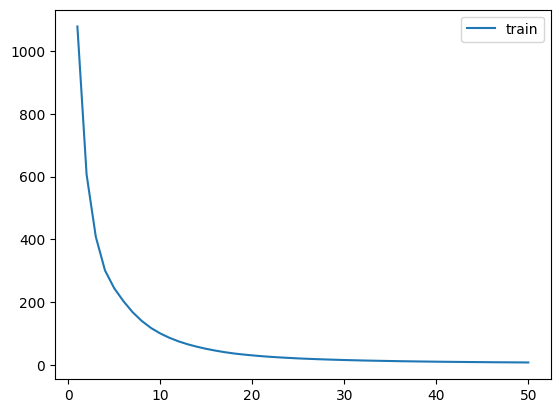

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['perplexity']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['perplexity'], label='train')
#sns.lineplot(x=epoch_count,  y=hist.history['val_loss'], label='valid')
plt.show()


### Predicción de próxima palabra

In [ ]:
# Keras pad_sequences
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
# Si la secuencia de entrada supera al input_seq_len (3) se trunca
# Si la secuencia es más corta se agregna ceros al comienzo

In [47]:
# Se utilizará gradio para ensayar el modelo
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos
# https://gradio.app/

!pip install -q gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 70.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.3 MB/s eta 0:00:00


In [52]:
import gradio as gr

def model_response(human_text, model):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=lambda x: model_response(x, model_2),
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://a9d334285ca8b26064.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://a9d334285ca8b26064.gradio.live


### Generación de secuencias

In [53]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [60]:
input_text='El tigre se encontró con'

generate_seq(model, tok, input_text, max_length=max_context_size, n_words=12)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


'El tigre se encontró con los hombres de la tarde y el hombre acosado por un asedio'

###  Beam search y muestreo aleatorio

In [61]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return tok.sequences_to_texts([seq])

In [62]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp=1):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  # idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = np.squeeze(model.predict(encoded))

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = np.squeeze(model.predict(input_update))

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens)

    return history_tokens

In [65]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=12,input='El tigre se encontró con')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

In [66]:
# veamos las salidas
decode(salidas[0])

['el tigre se encontró con los hombres de la conducta de los dioses indescifrables o de síntesis']

### Conclusiones
El modelo entrenado tuvo un muy mail desempeño en el entrenamiento además de overfitting. Cuestiones que podrían mejorarse:
- Agregar más capas o neuronaes
- Incrementar la cantidad de épocas
- Agregar BRNN

Es importante destacar que en este ejemplo estamos entrenando nuestro propios Embeddings, y para ello se requiere mucha data. En los ejemplos que realizaremos de aquí en más utilizaremos más datos, embeddings pre-enternados o modelos pre-entrenados.